---
# pRF Viewer

This notebook shows you how to read in the `pickle`-files that are generated by the line-scanning code. It shows you how to view the results on the surface using `pycortex`, plot specific pRFs/timecourses from vertices, and how to obtain size-response functions

In [31]:
from linescanning import (
    utils,
    prf,
    plotting,
    optimal
)
import os
import numpy as np
import matplotlib.pyplot as plt
opj = os.path.join

# Settings

The files produced by the line-scanning repository will generally live in `$DIR_DATA_DERIV/prf/<sub>/ses-<ses>`. You can specify the specific folders below, as well as particular subject settings (e.g., subject ID, session ID, task ID, and repetition time). It will then look for the following: 

- BOLD data (a `npy`-file ending on `_hemi-LR_desc-avg_bold.npy`, should live in the prf directory)
- Design matrix (a `mat`-file called `design_task-<taskID>`, should live in the prf directory)
- Model files (`pkl`-files containing `model-` flags in the filename)

In [79]:
# define project directory
proj_dir = "/data1/projects/MicroFunc/Zoey/projects" #"/data1/projects/MicroFunc/Jurjen/projects" 
proj_name = "pilot1"
deriv = opj(proj_dir, proj_name, "derivatives")

# define subject settings
sub = "005"
ses = "1"
task = "2R"
TR = 1.5

# find BOLD data
prf_dir = opj(deriv, "prf", f"sub-{sub}", f"ses-{ses}")
bold_file = opj(prf_dir, f"sub-{sub}_ses-{ses}_task-{task}_hemi-LR_desc-avg_bold.npy")
print(f"BOLD:\t{bold_file}")
dm_file = opj(prf_dir, f"design_task-{task}.mat")
print(f"Design:\t{dm_file}")
# find model files
model_files = {}
for model in ["gauss","norm","css","dog"]:
    pkl_file = opj(prf_dir, f"sub-{sub}_ses-{ses}_task-{task}_model-{model}_stage-iter_desc-prf_params.pkl")
    if os.path.exists(pkl_file):
        model_files[model] = pkl_file

for key,val in model_files.items():
    print(f"{key}:\t{val}")

BOLD:	/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_hemi-LR_desc-avg_bold.npy
Design:	/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/design_task-2R.mat
gauss:	/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl
norm:	/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl


# Load pRF and open viewer for plotting

In [80]:
# !call_ctxfilestore show_fs

/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/pycortex


Using `linescanning.optimal.pRFCalc`, we can quickly parse the pRF-estimates into a dataframe given the model-type (e.g., `norm`). This class then also created `pycortex` objects than can be opened by calling `.open_pycortex()`. For some reason, this seems to work better if your default browser is Chrome. The function will spit out colorbars for the different elements (`r2`, `eccentricity`, and `polar angle`), as well as the vertex ID with the highest variance explained.

Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 60202
max r2 = 0.85 | vert = 1968


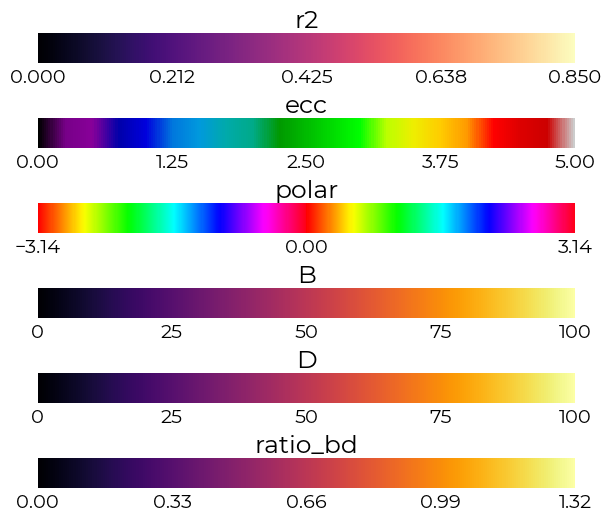

Stopping server


In [81]:
%matplotlib inline
check_model = "norm"

# plot parameters on surface
skip_ctx = False
prf_obj = optimal.pRFCalc(model_files[check_model], skip_cortex=skip_ctx)

if not skip_ctx:
    prf_obj.open_pycortex()

print(f"max r2 = {round(prf_obj.max_r2,2)} | vert = {prf_obj.max_r2_vert}")

# Initiate pRF object

In [82]:
# load_params function can deal with this type of dictionary input
model_files

{'gauss': '/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl',
 'norm': '/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl'}

We can then load in the data/models using the `linescanning.prf.pRFmodelFitting` class (see also the `pRFmodelFItting`-notebook). This class accepts the dictionary-like input printed above, and loads them in as `<model>_iter`, which stands for the iterative search parameters of a specified model. This we can then use when calling the `plot_vox()` function below.

In [83]:
# initiate object
obj = prf.pRFmodelFitting(
    bold_file,
    design_matrix=dm_file,
    TR=TR,
    model=check_model,
    verbose=True,
)

# load parameters
obj.load_params(
    model_files, 
    stage="iter",
    model=None
)

Reading design matrix from '/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/design_task-2R.mat'


Reading data from '/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_hemi-LR_desc-avg_bold.npy'
Skipped volumes was negative (-266216), transposing data to (266441, 221)
Design has 4 more volumes than timecourses, trimming from beginning of design to (54, 54, 221)
Reading settings from '/data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/misc/prf_analysis.yml'

---------------------------------------------------------------------------------------------------
Check these important settings!
 Screen distance: 196cm
 Screen size: 39.3cm
 TR: 1.5s
---------------------------------------------------------------------------------------------------

Instantiate HRF with: [1, 4.6, 0] (fit=True)
Using constraint(s): ['tc', 'tc']
Reading settings from '/data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_model-gauss_stage-iter_desc-prf_params.pkl' (safest option; overwrites other settings)

Here we can choose to plot the pRF and the timecourse (data+prediction) of a given vertex, with the model of our choosing. Here we choose `norm`, which represents the divisive-normalization model. If you have other models in the `model_files`-dictionary, you can specify those here to see how the prediction changes based on selected model

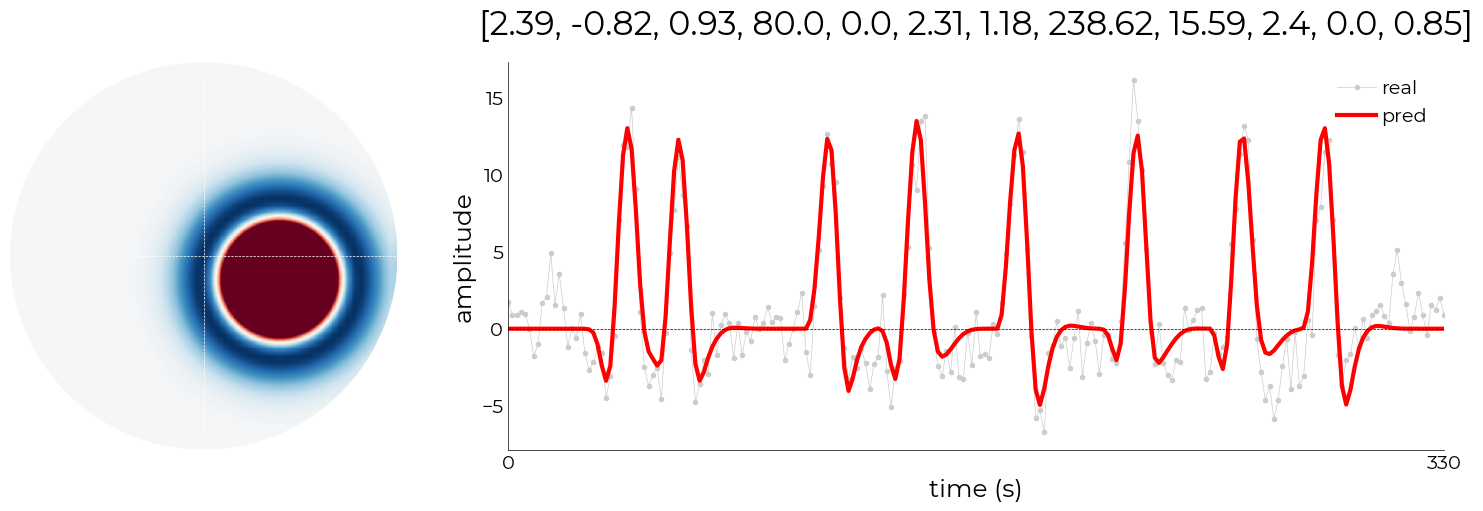

In [85]:
%matplotlib inline
plot_vert = prf_obj.max_r2_vert
_ = obj.plot_vox(vox_nr=plot_vert, model="norm", title="pars")

# Size-Response Functions

The DN-model allows for modeling of the response of pRFs given a certain stimulus size, as it's able to capture both non-linearities as the beginning of the curve and at the end. 

## Run SRF for all vertices

You can submit a job that creates SRFs for all vertices in the brain based on the DN-model parameters

In [86]:
# define command
split_file = os.path.basename(model_files["norm"]).split("_")
desc_idx = split_file.index("desc-prf")
base_name = "_".join(split_file[:desc_idx])+"_desc-srfs_centered"

cmd = f"qsub -N {base_name} -wd {os.path.dirname(model_files['norm'])} -q long.q {opj(os.environ.get('DIR_SCRIPTS'), 'bin', 'call_sizeresponse')} --in {model_files['norm']} --verbose"
print(cmd)

qsub -N sub-005_ses-1_task-2R_model-norm_stage-iter_desc-srfs_centered -wd /data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1 -q long.q /data1/projects/MicroFunc/Jurjen/programs/packages/linescanning/bin/call_sizeresponse --in /data1/projects/MicroFunc/Zoey/projects/pilot1/derivatives/prf/sub-005/ses-1/sub-005_ses-1_task-2R_model-norm_stage-iter_desc-prf_params.pkl --verbose


In [87]:
# run command
os.system(cmd)

Your job 32732 ("sub-005_ses-1_task-2R_model-norm_stage-iter_desc-srfs_centered") has been submitted


0

## Single-vertex SRF

Or you can run the process for a single vertex

 Max stimulation @1.64dva | ampl = 14.77
 Min stimulation @4.91dva | ampl = -7.59


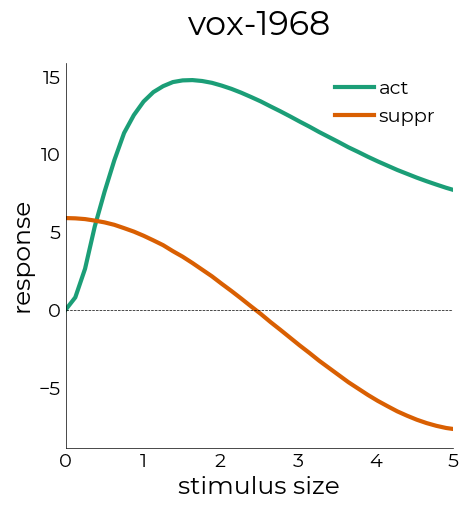

In [88]:
fig,axs = plt.subplots(figsize=(5,5))

# plot the model fit
pars,_,tc,pred = obj.plot_vox(
    vox_nr=plot_vert, 
    make_figure=False, 
    model="norm"
)

# calculate sizeresponse
SR_ = prf.SizeResponse(params=pars, model="norm")

## CENTERED PRF

# size response
fill_cent, fill_cent_sizes = SR_.make_stimuli(
    factor=1,
    dt="fill"
)

sr_cent_act = SR_.batch_sr_function(
    SR_.params_df,
    center_prf=True,
    stims=fill_cent,
    sizes=fill_cent_sizes
)

# hole-response
hole_cent, hole_cent_sizes = SR_.make_stimuli(
    factor=1,
    dt="hole"
)

sr_cent_norm = SR_.batch_sr_function(
    SR_.params_df,
    center_prf=True,
    stims=hole_cent,
    sizes=hole_cent_sizes
)

%matplotlib inline
## PLOT
plotting.LazyPlot(
    [df.iloc[:,0].values for df in [sr_cent_act,sr_cent_norm]],
    xx=fill_cent_sizes,
    color=["#1B9E77","#D95F02"],
    line_width=3,
    axs=axs,
    x_label="stimulus size",
    y_label="response",
    labels=["act","suppr"],
    add_hline=0,
    title=f"vox-{plot_vert}",
    x_lim=[0,5]
)

max_dva, max_val = SR_.find_stim_sizes(
    sr_cent_act[0].values,
    t="max",
    dt="fill",
    sizes=fill_cent_sizes,
    return_ampl=True
)
print(f" Max stimulation @{round(max_dva,2)}dva | ampl = {round(max_val,2)}")

min_dva, min_val = SR_.find_stim_sizes(
    sr_cent_norm[0].values,
    t="min",
    dt="fill",
    sizes=fill_cent_sizes,
    return_ampl=True
)
print(f" Min stimulation @{round(min_dva,2)}dva | ampl = {round(min_val,2)}")

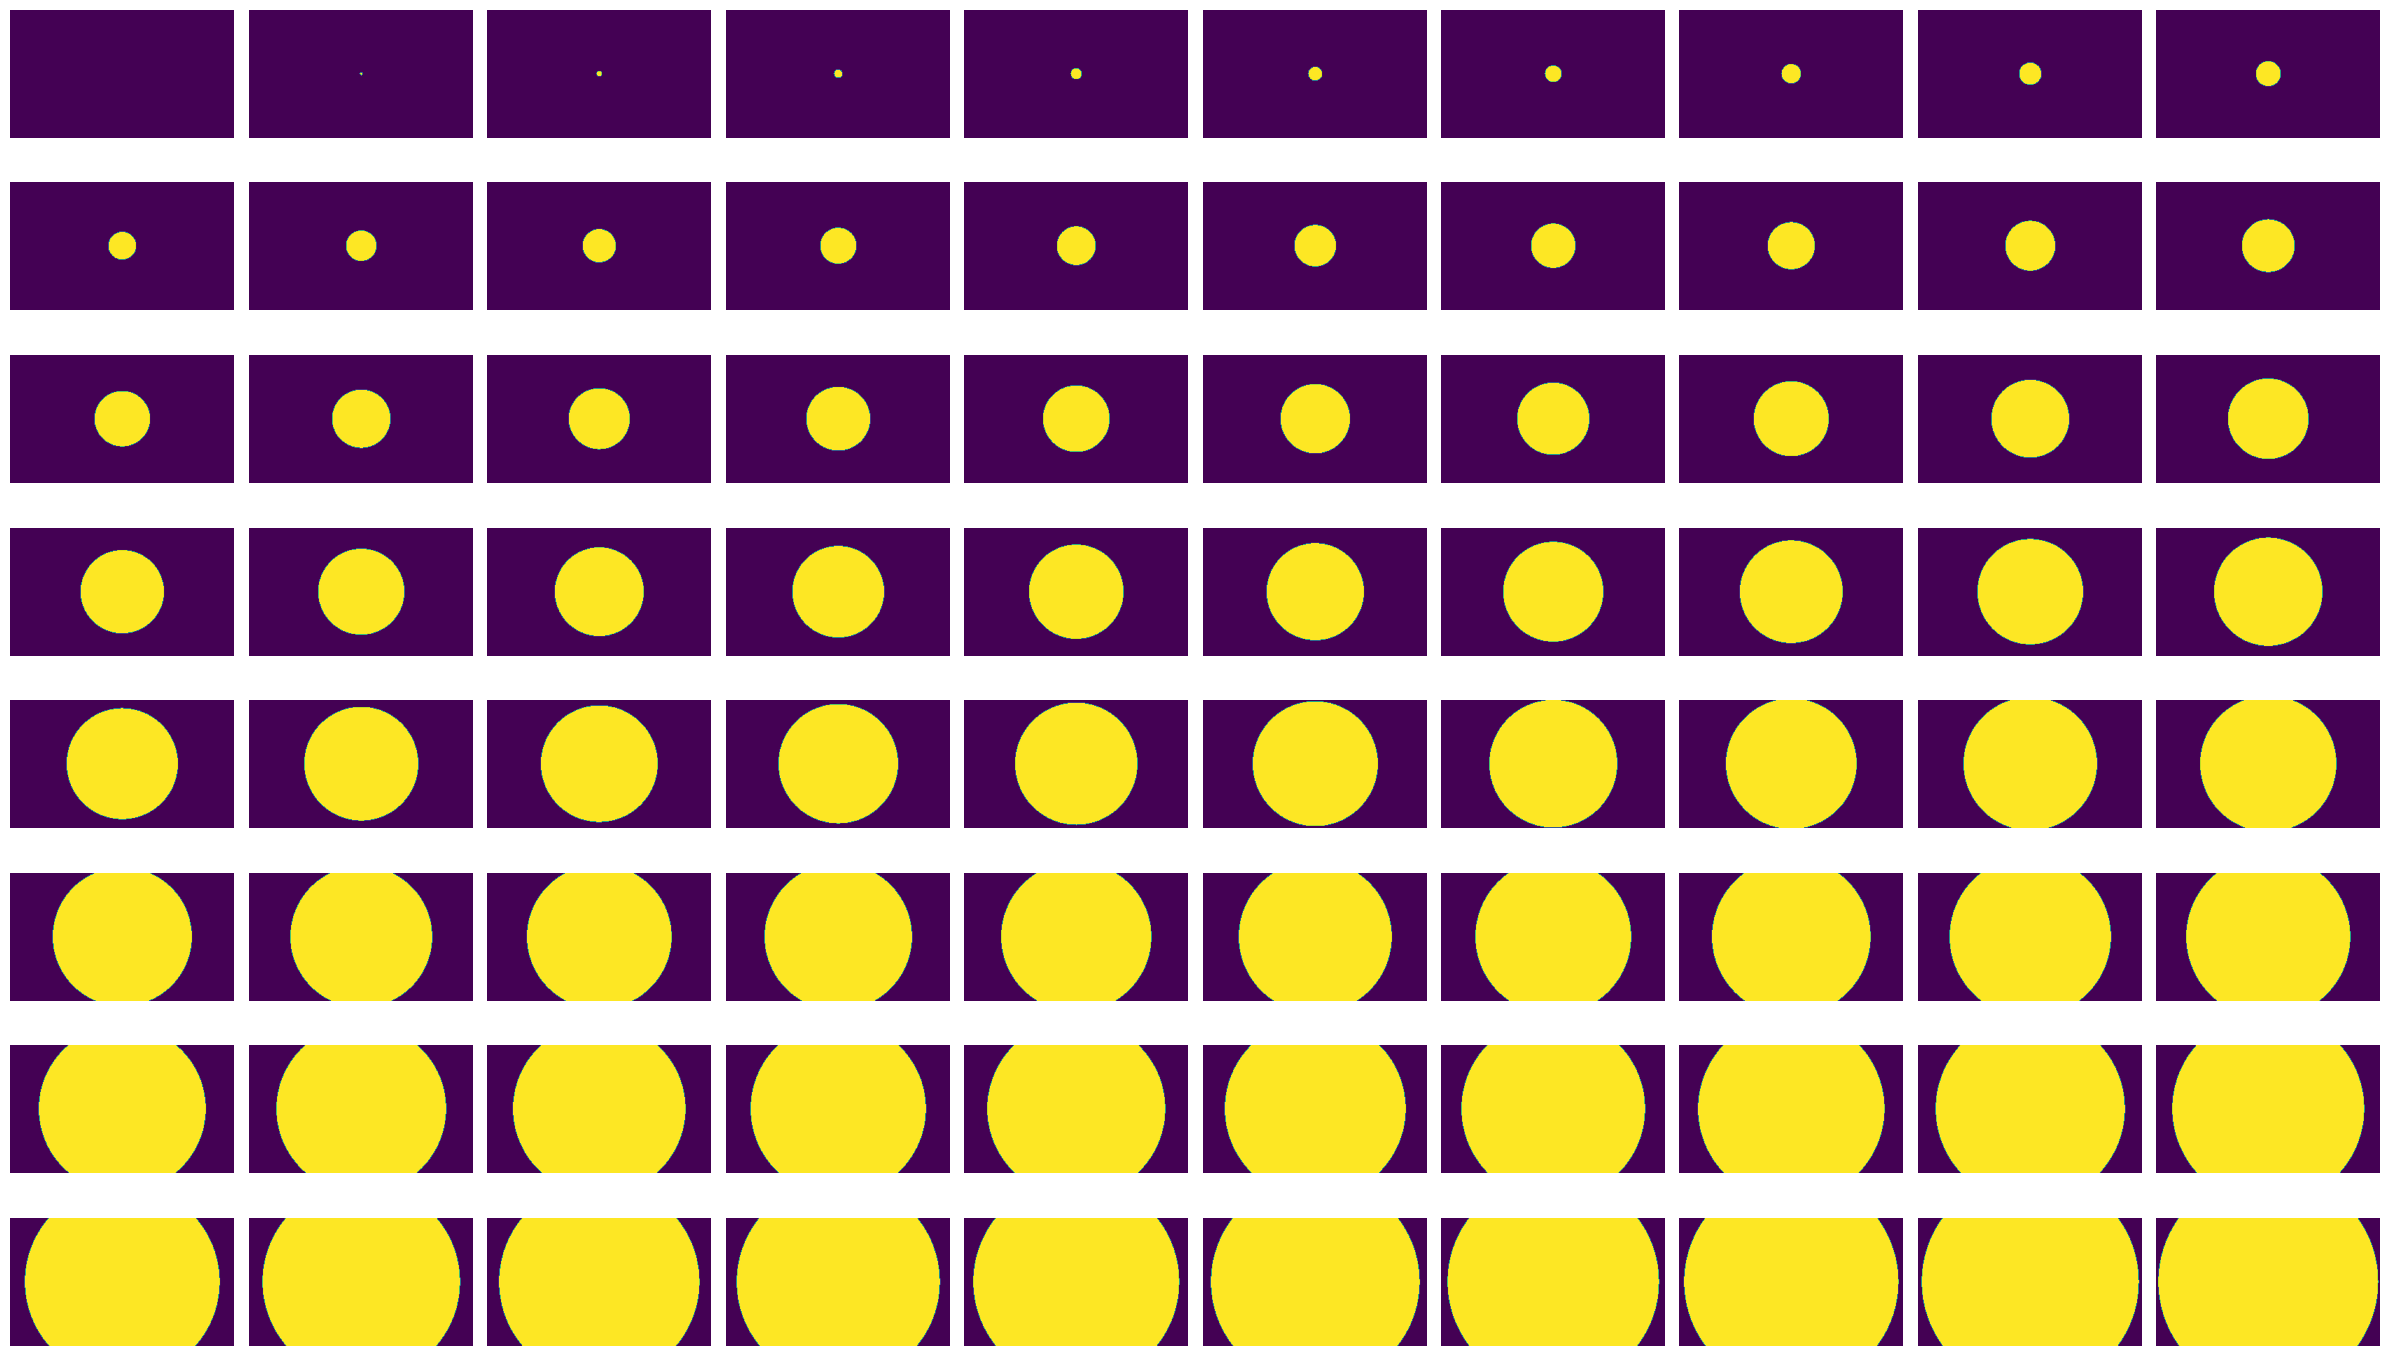

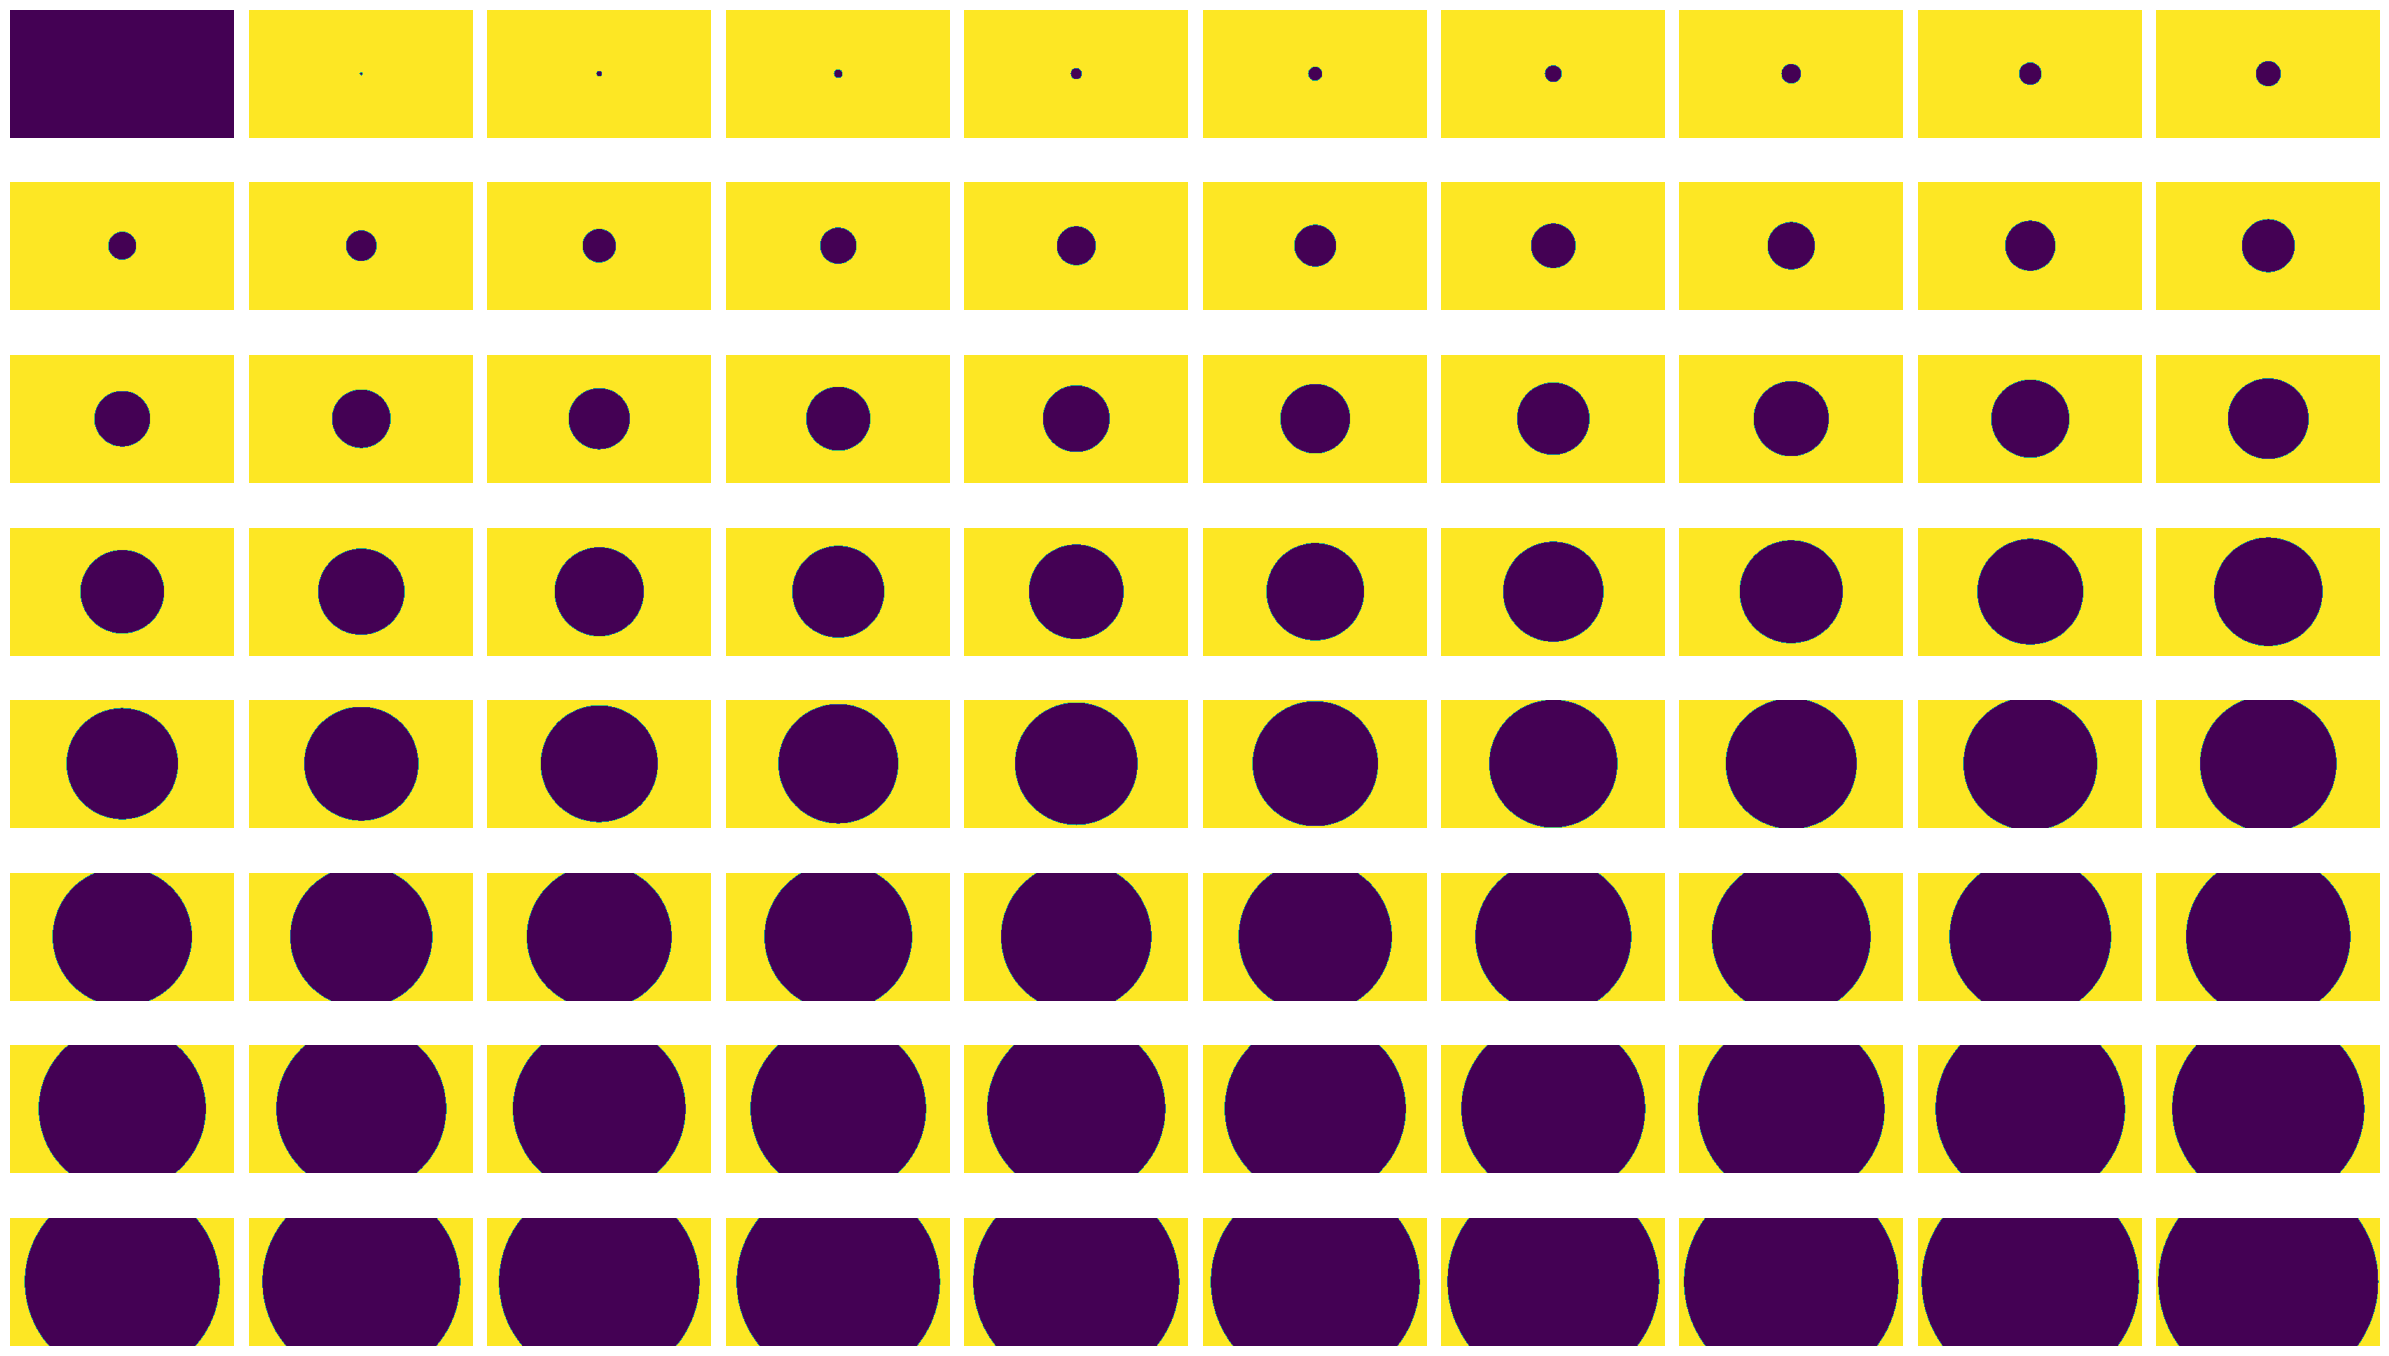

In [78]:
# plot stimuli
prf.plot_stims(fill_cent, extent=SR_.vf_extent, interval=2)
prf.plot_stims(hole_cent, extent=SR_.vf_extent, interval=2)